In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import fashion_mnist

In [2]:
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

In [3]:
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train = X_train.reshape(X_train.shape[0], -1) / 255.0  # Normalize and flatten
X_test = X_test.reshape(X_test.shape[0], -1) / 255.

print(f"Training data shape: {X_train.shape}, Training labels shape: {y_train.shape}")

Training data shape: (60000, 784), Training labels shape: (60000,)


In [4]:
unique, counts = np.unique(y_train, return_counts=True)
print("Class distribution in training set:", dict(zip(unique, counts)))

for class_id, count in zip(unique, counts):
    print(f"Class {class_id} ({class_names[class_id]}): {count} samples")

Class distribution in training set: {np.uint8(0): np.int64(6000), np.uint8(1): np.int64(6000), np.uint8(2): np.int64(6000), np.uint8(3): np.int64(6000), np.uint8(4): np.int64(6000), np.uint8(5): np.int64(6000), np.uint8(6): np.int64(6000), np.uint8(7): np.int64(6000), np.uint8(8): np.int64(6000), np.uint8(9): np.int64(6000)}
Class 0 (T-shirt/top): 6000 samples
Class 1 (Trouser): 6000 samples
Class 2 (Pullover): 6000 samples
Class 3 (Dress): 6000 samples
Class 4 (Coat): 6000 samples
Class 5 (Sandal): 6000 samples
Class 6 (Shirt): 6000 samples
Class 7 (Sneaker): 6000 samples
Class 8 (Bag): 6000 samples
Class 9 (Ankle boot): 6000 samples


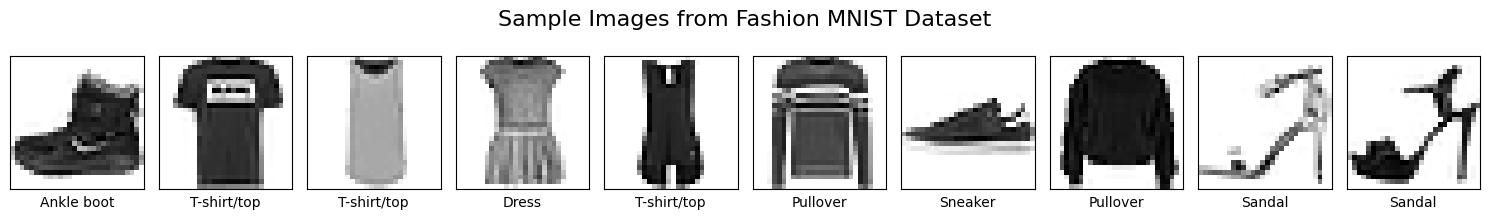

In [5]:
plt.figure(figsize=(15,2))
num_images = 10

for i in range (num_images):
    plt.subplot(1, num_images, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])

plt.suptitle('Sample Images from Fashion MNIST Dataset', fontsize=16)
plt.tight_layout()
plt.show()

Initialise Neural Network

In [26]:
def initialise(layer_sizes, activation='relu', seed=42):
    np.random.seed(seed)
    num_layers = len(layer_sizes) - 1

    # Initialize weights and biases using Xavier initialisation
    weights = []
    biases = []

    for i in range(num_layers):
        weight_matrix = np.random.randn(layer_sizes[i], layer_sizes[i+1]) * np.sqrt(2 / (layer_sizes[i] + layer_sizes[i+1]))
        bias_vector = np.zeros((1, layer_sizes[i+1]))
        weights.append(weight_matrix)
        biases.append(bias_vector)
    
    print(f"Initialized network with layer sizes: {layer_sizes}")
    print(f"Activation function: {activation}")
    print(f"Number of layers: {num_layers}")
    return weights, biases, layer_sizes, activation

In [7]:
# Network architecture
layer_sizes = [784, 128, 10]  # Input layer, one hidden layers, output layer

weights, biases, _, activation = initialise(layer_sizes, activation='relu', seed=42) 

Initialized network with layer sizes: [784, 128, 10]
Activation function: relu
Number of layers: 2


In [8]:
def count_parameters(weights, biases):
    total_params = 0
    for w, b in zip(weights, biases):
        total_params += w.size + b.size
    return total_params

In [24]:
learning_rate = 0.1
batch_size = 64
epochs = 50

print(f"\n Training parameters:")
print(f"- Learning rate: {learning_rate}")
print(f"- Batch size: {batch_size}")
print(f"- Number of epochs: {epochs}")


 Training parameters:
- Learning rate: 0.1
- Batch size: 64
- Number of epochs: 50


In [10]:
train_loss_history = []
train_acc_history = []
test_acc_history = []

Activation functiosn with their respective derivative

In [11]:
def relu(x):
    return np.maximum(0, x)
def relu_derivative(x):
    return (x > 0).astype(float)

def tanh(x):
    return np.tanh(x)
def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    sig = sigmoid(x)
    return sig * (1 - sig)

def apply_activation(x, activation_type):
    if activation_type == 'relu':
        return relu(x)
    elif activation_type == 'tanh':
        return tanh(x)
    elif activation_type == 'sigmoid':
        return sigmoid(x)
    else:
        raise ValueError("Unsupported activation function: {activation_type}")

def apply_activation_derivative(x, activation_type):
    if activation_type == 'relu':
        return relu_derivative(x)
    elif activation_type == 'tanh':
        return tanh_derivative(x)
    elif activation_type == 'sigmoid':
        return sigmoid_derivative(x)
    else:
        raise ValueError("Unsupported activation function: {activation_type}")

Forward propagation throughout the network

mathematical formulation: 
    For each layer *l*: 
    Z[l] = A[l-1] @ W[l] + b[l] (Linear transformation)
    A[l] = activation(Z[l]) (Activation Function)

    Final Layer uses Softmax for classifcation

    Args: 
        X: Input data (batch_size, input_features)
        return_cache: If true return immediate values for back prop

    returns: 
        Predictions: Final output probaility (batch_size, num_classes)
        cache: Dictionary of intermediate values (if return_cache=True)

In [28]:
def softmax(x):

    '''
    Compute the softmax activation for a vector or a matrix of logits.

    Args: 
        x: A numpy array of shape (n,) or (m, n) where n is the number of classes.
    Returns:
        A numpy array of the same shape as x representing the softmax probabilities.
    '''

    shifted_x = x - np.max(x, axis=-1, keepdims=True)  # Prevent overflow
    exp_x = np.exp(shifted_x)

    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [29]:
def forward_pass(X, weights, biases, activation_type, return_cache=False):
    cache = {}
    A = X
    cache['A0'] = X # Store input as activation of layer 0

    num_layers = len(weights)

    for i in range(num_layers):
        # Hidden Layers
        Z = np.dot(A, weights[i]) + biases[i]
        
        if i < num_layers - 1:
            A = apply_activation(Z, activation_type)
        else:
            A = softmax(Z)  # Output layer with softmax
        
        cache[f'Z{i+1}'] = Z
        cache[f'A{i+1}'] = A

    if return_cache:
        return A, cache
    return A

def predict(X, weights, biases, activation_type):
    probabilities = forward_pass(X, weights, biases, activation_type, return_cache=False)
    return np.argmax(probabilities, axis=1)

In [30]:
def testing_forward_pass():
    print("="*50)
    print("Testing forward pass")
    print("="*50)

    X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=np.float32)
    y = np.array([0,1,1,0], dtype=int)  # XOR truth table

    weights, biases, layer_sizes, activation = initialise(layer_sizes=[2, 2, 2], activation='relu')

    print("\nNetwork Architecture:")
    for i in range(len(layer_sizes)-1):
        print(f" Layer {i+1}: {layer_sizes[i]} -> {layer_sizes[i+1]}")

    # forward pass
    print(f"\n{'-'*30}")
    print("FORWARD PASS:")
    print(f"{'-'*30}")

    predictions, cache = forward_pass(X, weights, biases, activation, return_cache=True)
    predicted_classes = np.argmax(predictions, axis=1)

    print(f"\nFinal Results:")
    print(f" Predicted Probabilities:\n{predictions}")
    print(f" Predicted Classes: {predicted_classes}")
    print(f" True Classes: {y}")
    print(f"Accuracy: {np.mean(predicted_classes == y) * 100:.2f}%")

    return weights, biases, layer_sizes, activation, X, y, cache

Loss Function

In [31]:
def cross_entropy_loss(y_true, y_pred):

    '''
    Compute the cross-entropy loss between true labels and predicted probabilities.
    Mathematical Formula:
    L = -1/N * Σ(i=1 to N) Σ(j=1 to C) y_true[i,j] * log(y_pred[i,j])

    Args:
        y_true: A numpy array of shape (m, n) representing one-hot encoded true labels.
        y_pred: A numpy array of shape (m, n) representing predicted probabilities.
    Returns:
        A float representing the average cross-entropy loss over the batch.
    '''
    batch_size = y_pred.shape[0]
    num_classes = y_pred.shape[1]

    if y_true.ndim == 1:
        y_true_onehot = np.zeros((batch_size, num_classes))
        y_true_onehot[np.arange(batch_size), y_true] = 1
    else:
        y_true_onehot = y_true

    epsilon = 1e-15
    y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

    # Calclulate cross-entropy loss
    sample_losses = -np.sum(y_true_onehot * np.log(y_pred_clipped), axis=1)

    return np.mean(sample_losses), y_true_onehot

In [ ]:
def backward_pass(cache, y_true_onehot, weights, activation_type):
    """
    Backward propagation through the network
    
    Mathematical Formulation:
    
    For output layer (L):
    dZ[L] = A[L] - y_true  (gradient after softmax + cross-entropy)
    dW[L] = (1/m) * A[L-1].T @ dZ[L]
    db[L] = (1/m) * sum(dZ[L], axis=0)
    
    For hidden layers (l = L-1, L-2, ..., 1):
    dA[l] = dZ[l+1] @ W[l+1].T
    dZ[l] = dA[l] * activation_derivative(Z[l])
    dW[l] = (1/m) * A[l-1].T @ dZ[l]
    db[l] = (1/m) * sum(dZ[l], axis=0)
    
    Args:
        cache: Dictionary containing forward pass intermediate values
        y_true_onehot: One-hot encoded true labels (batch_size, num_classes)
        weights: List of weight matrices
        activation_type: Type of activation function used in hidden layers
    
    Returns:
        gradients: Dictionary containing gradients for weights and biases
    """
    
    num_layers = len(weights)
    batch_size = y_true_onehot.shape[0]
    
    # Initialize gradients lists with correct size
    dW_gradients = [None] * num_layers
    db_gradients = [None] * num_layers
    
    # print(f"Starting backpropagation...")
    # print(f"Batch size: {batch_size}, Number of layers: {num_layers}")
    
    # === OUTPUT LAYER GRADIENTS ===
    # For softmax + cross-entropy, the gradient simplifies to: dZ = A - y_true
    A_output = cache[f'A{num_layers}']  # Final predictions (after softmax)
    dZ = A_output - y_true_onehot  # Shape: (batch_size, num_classes)
    
    print(f"Output layer gradient dZ shape: {dZ.shape}")
    
    # Gradients for output layer weights and biases (last layer index)
    A_prev = cache[f'A{num_layers-1}']  # Activations from previous layer
    dW = (1/batch_size) * A_prev.T @ dZ  # Shape: (prev_layer_size, num_classes)
    db = (1/batch_size) * np.sum(dZ, axis=0, keepdims=True)  # Shape: (1, num_classes)
    
    # Store output layer gradients at correct index
    dW_gradients[num_layers-1] = dW
    db_gradients[num_layers-1] = db
    
    print(f"Output layer (index {num_layers-1}): dW shape = {dW.shape}, db shape = {db.shape}")
    
    # === HIDDEN LAYER GRADIENTS ===
    # Work backwards from layer (L-1) to layer 0
    for layer_idx in range(num_layers - 2, -1, -1):  # num_layers-2, num_layers-3, ..., 0
        # Propagate error backwards: dA = dZ_next @ W_next.T
        next_layer_idx = layer_idx + 1
        dA = dZ @ weights[next_layer_idx].T  # Shape: (batch_size, current_layer_size)
        
        # Get pre-activation values and compute activation derivative
        Z_current = cache[f'Z{layer_idx+1}']  # Pre-activation values (cache uses 1-based indexing)
        activation_derivative = apply_activation_derivative(Z_current, activation_type)
        
        # Apply chain rule: dZ = dA * activation_derivative
        dZ = dA * activation_derivative  # Element-wise multiplication
        
        # Get activations from previous layer
        A_prev = cache[f'A{layer_idx}']  # Previous layer activations
        
        # Calculate weight and bias gradients
        dW = (1/batch_size) * A_prev.T @ dZ
        db = (1/batch_size) * np.sum(dZ, axis=0, keepdims=True)
        
        # Store gradients at correct index
        dW_gradients[layer_idx] = dW
        db_gradients[layer_idx] = db
        
        # print(f"Layer {layer_idx}: dZ shape = {dZ.shape}, dW shape = {dW.shape}, db shape = {db.shape}")
    
    gradients = {'dW': dW_gradients, 'db': db_gradients}
    
    # print("Backpropagation complete!")
    return gradients

In [33]:
def update_weights(weights, biases, gradients, learning_rate):
    """
    Update weights and biases using gradients
    
    Mathematical Update Rule:
    W_new = W_old - learning_rate * dW
    b_new = b_old - learning_rate * db
    
    Args:
        weights: List of current weight matrices
        biases: List of current bias vectors
        gradients: Dictionary containing gradients
        learning_rate: Step size for gradient descent
    
    Returns:
        Updated weights and biases (in-place modification)
    """
    num_layers = len(weights)
    for i in range(num_layers):
        weights[i] -= learning_rate * gradients['dW'][i]
        biases[i] -= learning_rate * gradients['db'][i].reshape(1, -1)
    return weights, biases

In [34]:
def train_one_step(X, y_true, weights, biases, activation_type, learning_rate=0.01):
    """
    Complete training step: forward pass + backward pass + weight update
    
    Args:
        X: Input data (batch_size, input_features)
        y_true: True labels (batch_size,)
        weights: List of weight matrices
        biases: List of bias vectors
        activation_type: Activation function for hidden layers
        learning_rate: Learning rate for gradient descent
    
    Returns:
        loss: Current loss value
        accuracy: Current accuracy percentage
        weights: Updated weights
        biases: Updated biases
    """
    # Forward pass
    predictions, cache = forward_pass(X, weights, biases, activation_type, return_cache=True)
    
    # Calculate loss
    loss, y_true_onehot = cross_entropy_loss(y_true, predictions)
    
    # Calculate accuracy
    predicted_classes = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_classes == y_true) * 100
    
    # Backward pass
    gradients = backward_pass(cache, y_true_onehot, weights, activation_type)
    
    # Update weights
    weights, biases = update_weights(weights, biases, gradients, learning_rate)
    
    return loss, accuracy, weights, biases

In [35]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")

    indices = np.random.permutation(X_train.shape[0])
    X_train_shuffled = X_train[indices]
    y_train_shuffled = y_train[indices]

    # Track metrics for the epoch
    epoch_losses = []
    epoch_accuracies = []

    #train in mini-batches
    n_batches = len(X_train) // batch_size

    for batch_idx in range(n_batches):
        start_idx = batch_idx * batch_size
        end_idx = start_idx + batch_size

        X_batch = X_train_shuffled[start_idx:end_idx]
        y_batch = y_train_shuffled[start_idx:end_idx]

        loss, accuracy, weights, biases = train_one_step(
            X_batch, y_batch, weights, biases, activation, learning_rate
        )
        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

        # Print batch metrics every 500 batches
        if batch_idx % 500 == 0:
            print(f" Batch {batch_idx+1}/{n_batches} - Loss: {loss:.4f}, Accuracy: {accuracy:.2f}%")

    avg_train_loss = np.mean(epoch_losses)
    avg_train_acc = np.mean(epoch_accuracies)

    test_subset_size = 1000
    test_indices = np.random.choice(X_test.shape[0], test_subset_size, replace=False)
    X_test_subset = X_test[test_indices]
    y_test_subset = y_test[test_indices]

    test_predictions = forward_pass(X_test_subset, weights, biases, activation, return_cache=False)
    test_predicted_classes = np.argmax(test_predictions, axis=1)
    test_accuracy = np.mean(test_predicted_classes == y_test_subset) * 100

    train_loss_history.append(avg_train_loss)
    train_acc_history.append(avg_train_acc)
    test_acc_history.append(test_accuracy)

    print(f" Epoch {epoch+1} complete - Avg Loss: {avg_train_loss:.4f}, Avg Train Acc: {avg_train_acc:.2f}%, Test Acc: {test_accuracy:.2f}%\n")
    print()
print("Training completed")

Epoch 1/50
Output layer gradient dZ shape: (64, 10)
Output layer (index 1): dW shape = (128, 10), db shape = (1, 10)
Backpropagation complete!
 Batch 1/937 - Loss: 0.4405, Accuracy: 87.50%
Output layer gradient dZ shape: (64, 10)
Output layer (index 1): dW shape = (128, 10), db shape = (1, 10)
Backpropagation complete!
Output layer gradient dZ shape: (64, 10)
Output layer (index 1): dW shape = (128, 10), db shape = (1, 10)
Backpropagation complete!
Output layer gradient dZ shape: (64, 10)
Output layer (index 1): dW shape = (128, 10), db shape = (1, 10)
Backpropagation complete!
Output layer gradient dZ shape: (64, 10)
Output layer (index 1): dW shape = (128, 10), db shape = (1, 10)
Backpropagation complete!
Output layer gradient dZ shape: (64, 10)
Output layer (index 1): dW shape = (128, 10), db shape = (1, 10)
Backpropagation complete!
Output layer gradient dZ shape: (64, 10)
Output layer (index 1): dW shape = (128, 10), db shape = (1, 10)
Backpropagation complete!
Output layer gradie

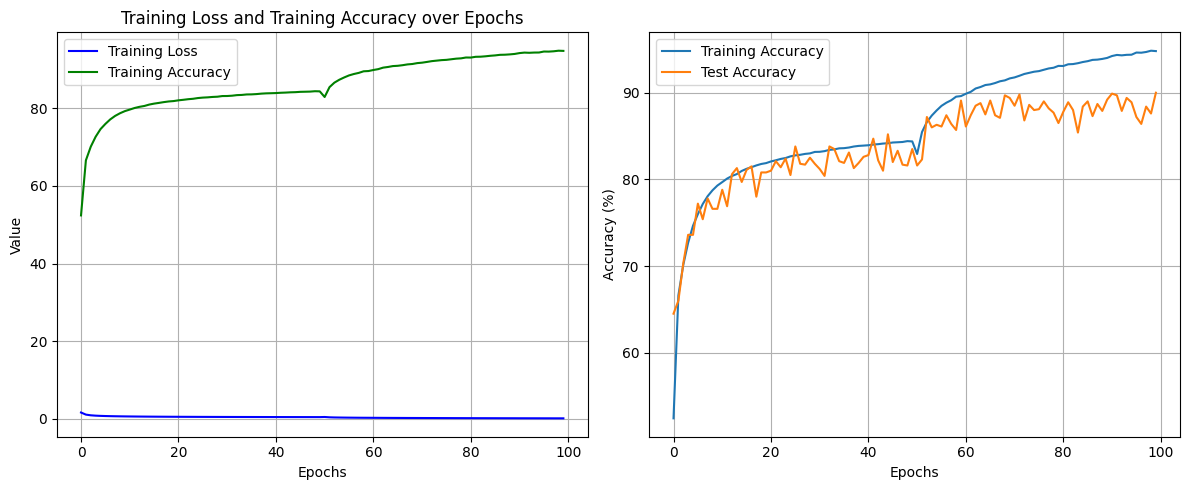

In [38]:
# Errors and Accuracy Plots
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Training Loss', color='blue')
plt.plot(train_acc_history, label='Training Accuracy', color='green')
plt.title('Training Loss and Training Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Training Accuracy')
plt.plot(test_acc_history, label='Test Accuracy')  # Add this!
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Total misclassified: 1101 out of 10000
Test accuracy: 88.99%


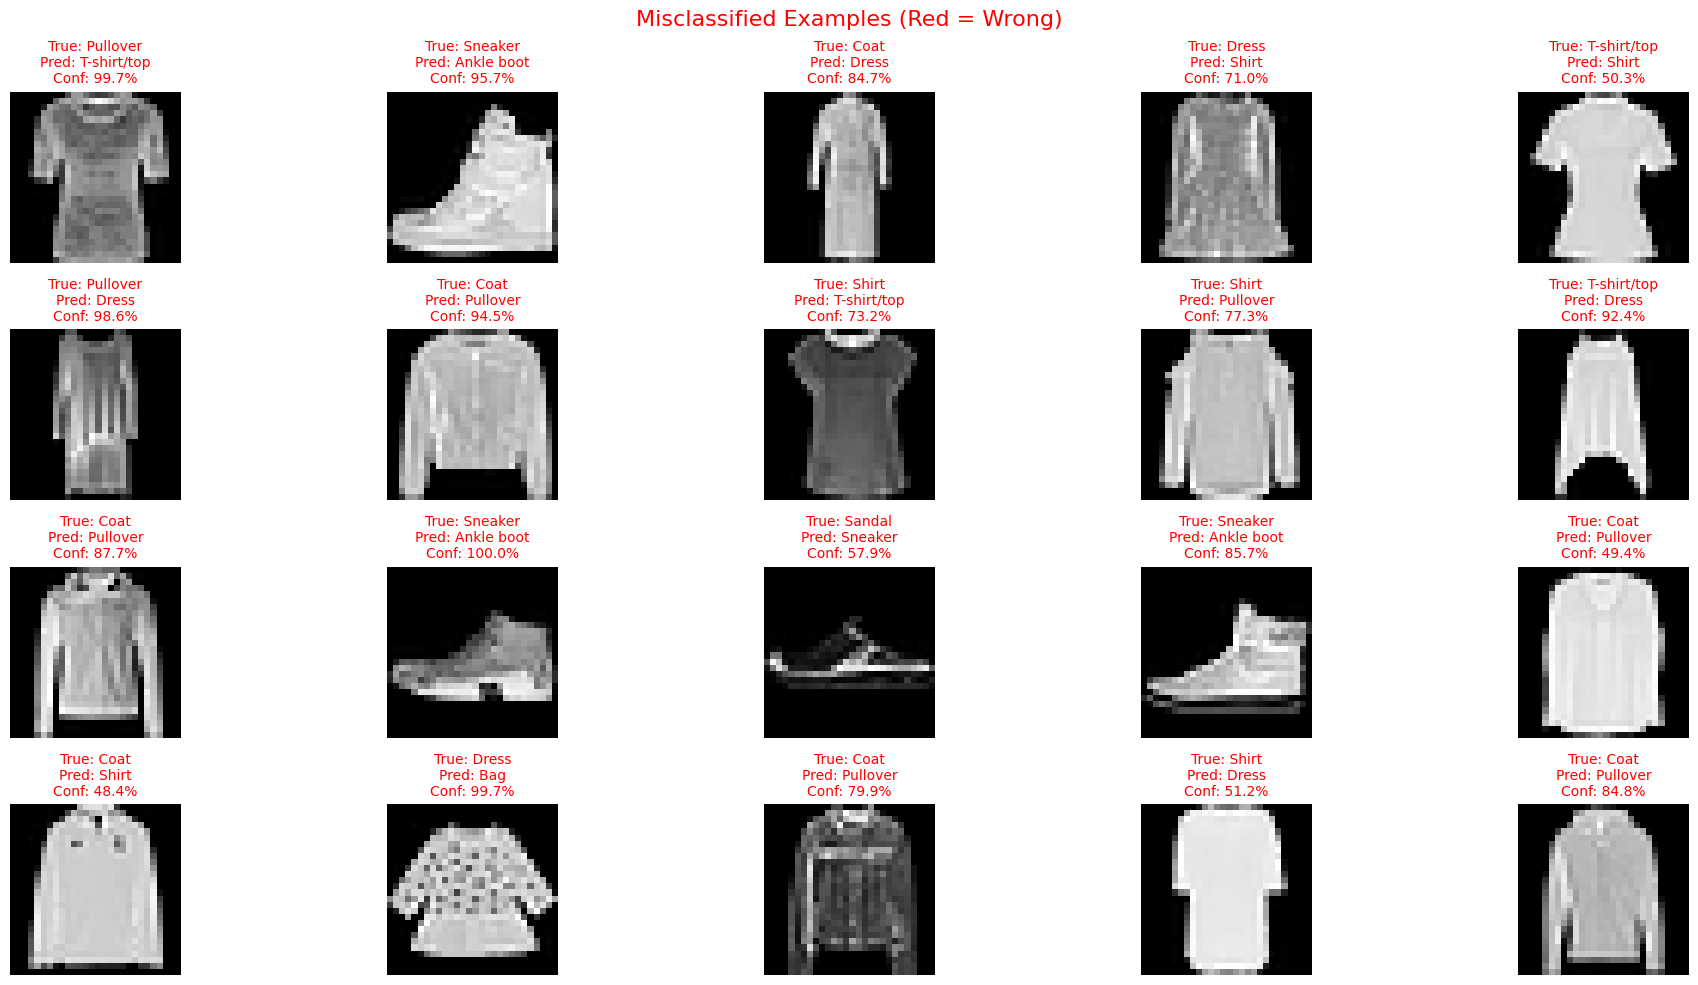


Most common misclassifications:
  Shirt        → T-shirt/top : 119 times
  Coat         → Pullover    : 108 times
  Shirt        → Pullover    : 96 times
  T-shirt/top  → Shirt       : 78 times
  Coat         → Shirt       : 69 times
  Pullover     → Coat        : 66 times
  Pullover     → Shirt       : 52 times
  Sneaker      → Ankle boot  : 50 times
  Shirt        → Coat        : 46 times
  T-shirt/top  → Dress       : 39 times


In [40]:
test_predictions_all = []
test_batch_size = 1000

for i in range(0, len(X_test), test_batch_size):
    batch_end = min(i + test_batch_size, len(X_test))
    batch_predictions = forward_pass(X_test[i:batch_end], weights, biases, activation)
    test_predictions_all.append(batch_predictions)

# Combine all predictions
all_test_predictions = np.vstack(test_predictions_all)
predicted_classes = np.argmax(all_test_predictions, axis=1)

# Find misclassified examples
misclassified_indices = np.where(predicted_classes != y_test)[0]
print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_test)}")
print(f"Test accuracy: {100 * (1 - len(misclassified_indices)/len(y_test)):.2f}%")

# Visualize misclassified examples
num_examples = 20
random_wrong = np.random.choice(misclassified_indices, min(num_examples, len(misclassified_indices)), replace=False)

plt.figure(figsize=(20, 10))

for i, idx in enumerate(random_wrong):
    plt.subplot(4, 5, i + 1)
    
    # Get the image (reshape back to 28x28)
    img = X_test[idx].reshape(28, 28)
    
    # Get predictions
    true_class = y_test[idx]
    pred_class = predicted_classes[idx]
    confidence = all_test_predictions[idx][pred_class] * 100
    
    # Display image
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    
    # Title with true vs predicted
    plt.title(f'True: {class_names[true_class]}\n'
              f'Pred: {class_names[pred_class]}\n'
              f'Conf: {confidence:.1f}%',
              fontsize=10, color='red')

plt.suptitle('Misclassified Examples (Red = Wrong)', fontsize=16, color='red')
plt.tight_layout()
plt.show()

# Show confusion patterns - which classes get confused most
print("\nMost common misclassifications:")
confusion_pairs = []
for idx in misclassified_indices:
    true_class = y_test[idx]
    pred_class = predicted_classes[idx]
    confusion_pairs.append((true_class, pred_class))

from collections import Counter
top_confusions = Counter(confusion_pairs).most_common(10)

for (true_cls, pred_cls), count in top_confusions:
    print(f"  {class_names[true_cls]:12s} → {class_names[pred_cls]:12s}: {count} times")

In [ ]:
if __name__ == "__main__":
    print("\n" + "="*60)
    print("BACKPROPAGATION IMPLEMENTATION COMPLETE!")
    print("="*60)
    print("Key functions implemented:")
    print("- backward_pass(): Calculates gradients")
    print("- update_weights(): Updates parameters using gradients") 
    print("- train_one_step(): Complete training iteration")

TESTING BACKPROPAGATION ON XOR PROBLEM
XOR Dataset:
X:
[[0. 0.]
 [0. 1.]
 [1. 0.]
 [1. 1.]]
y: [0 1 1 0]
Initialized network with layer sizes: [2, 4, 2]
Activation function: relu
Number of layers: 2

Initial network architecture: [2, 4, 2]
Activation: relu

Training for 10 steps with learning_rate = 0.1
------------------------------------------------------------
Starting backpropagation...
Batch size: 4, Number of layers: 2
Output layer gradient dZ shape: (4, 2)
Output layer (index 1): dW shape = (4, 2), db shape = (1, 2)
Layer 0: dZ shape = (4, 4), dW shape = (2, 4), db shape = (1, 4)
Backpropagation complete!
Step  1: Loss = 0.719186, Accuracy =  75.0%
Starting backpropagation...
Batch size: 4, Number of layers: 2
Output layer gradient dZ shape: (4, 2)
Output layer (index 1): dW shape = (4, 2), db shape = (1, 2)
Layer 0: dZ shape = (4, 4), dW shape = (2, 4), db shape = (1, 4)
Backpropagation complete!
Starting backpropagation...
Batch size: 4, Number of layers: 2
Output layer gradie